<div style="text-align:center; padding: 20px 0 12px 0; border-bottom: 2.5px solid #1a237e; margin-bottom: 22px;">
  <h1 style="font-size:2.5em; color:#1a237e; margin-bottom:0.2em; font-weight:bold; letter-spacing:1px;">Deep Learning y Sistemas Inteligentes</h1>
  <h2 style="font-size:1.3em; color:#3949ab; font-weight:600; margin-top:0;">Hoja de Trabajo 2</h2>
  <div style="font-size:1.1em; color:#222; margin-top:18px;">
    <b>Integrantes:</b><br>
    Mónica Salvatierra<br>
    Derek Arreaga<br>
    Paula Barillas
  </div>
  <div style="margin-top:10px; font-size:1em;">
    <a href="https://github.com/paulabaal12/HT2-DEEP" target="_blank" style="color:#1565c0; text-decoration:underline; font-weight:bold;">Repositorio GitHub: paulabaal12/HT2-DEEP</a>
  </div>
</div>

# Ejercicio 1 - Experimentación Práctica

## Task 1 - Preparación del conjunto de datos

In [13]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd

# dataset Iris
iris = load_iris()
X = iris.data.astype(np.float32)
y = iris.target.astype(np.int64)

# entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# tensores de PyTorch
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val)

## Task 2 - Arquitectura modelo

In [8]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, p_dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p_dropout)  # (por ahora p=0; se usará en Task 4)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # logits
        return x

input_dim = X_train.shape[1]          # 4 features
hidden_dim = 16
output_dim = len(np.unique(y))        # 3 clases

# instanciar el modelo
model = FeedforwardNN(input_dim, hidden_dim, output_dim)
print(model)

FeedforwardNN(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.0, inplace=False)
)


## Task 3 - Funciones de Pérdida


=== Entrenando con función de pérdida: cross_entropy ===
Epoch 01/50 | Train Loss: 1.2178 Acc: 0.333 F1: 0.167 | Val Loss: 1.1390 Acc: 0.333 F1: 0.167
Epoch 05/50 | Train Loss: 1.0150 Acc: 0.333 F1: 0.220 | Val Loss: 0.9889 Acc: 0.400 F1: 0.287
Epoch 10/50 | Train Loss: 0.8612 Acc: 0.667 F1: 0.556 | Val Loss: 0.8210 Acc: 0.667 F1: 0.556
Epoch 15/50 | Train Loss: 0.6695 Acc: 0.675 F1: 0.574 | Val Loss: 0.6302 Acc: 0.667 F1: 0.556
Epoch 20/50 | Train Loss: 0.5097 Acc: 0.692 F1: 0.608 | Val Loss: 0.4855 Acc: 0.733 F1: 0.683
Epoch 25/50 | Train Loss: 0.4068 Acc: 0.875 F1: 0.870 | Val Loss: 0.3943 Acc: 0.900 F1: 0.898
Epoch 30/50 | Train Loss: 0.3319 Acc: 0.967 F1: 0.967 | Val Loss: 0.3242 Acc: 0.967 F1: 0.967
Epoch 35/50 | Train Loss: 0.2607 Acc: 0.967 F1: 0.967 | Val Loss: 0.2559 Acc: 1.000 F1: 1.000
Epoch 40/50 | Train Loss: 0.1947 Acc: 0.975 F1: 0.975 | Val Loss: 0.1937 Acc: 1.000 F1: 1.000
Epoch 45/50 | Train Loss: 0.1432 Acc: 0.975 F1: 0.975 | Val Loss: 0.1460 Acc: 1.000 F1: 1.000
Ep

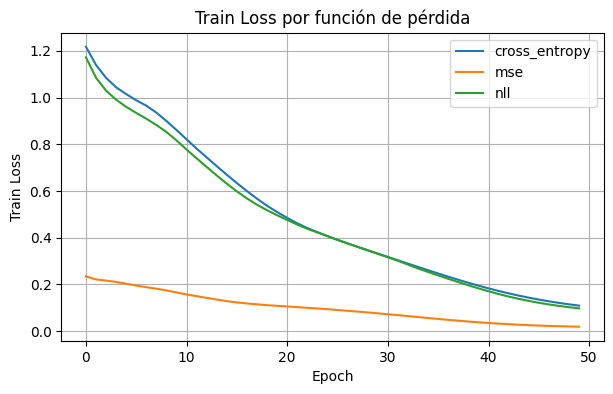

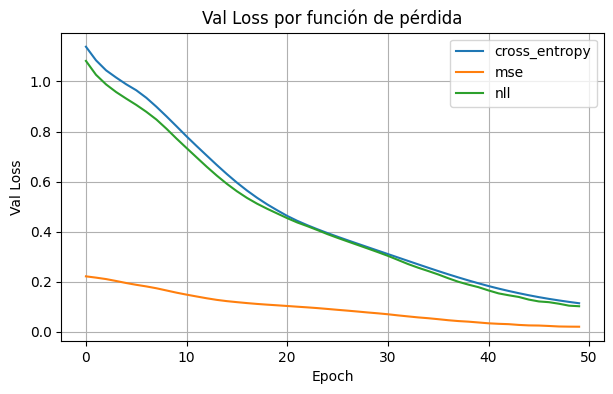

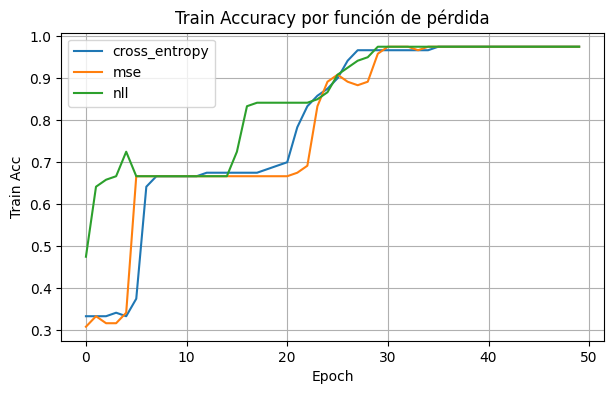

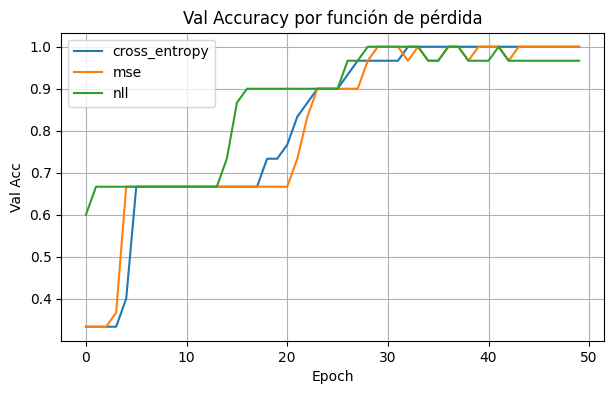

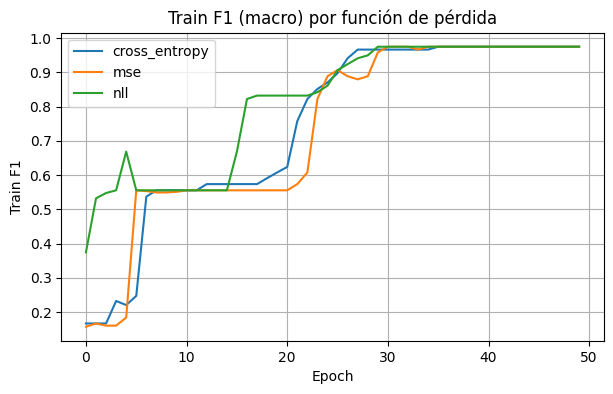

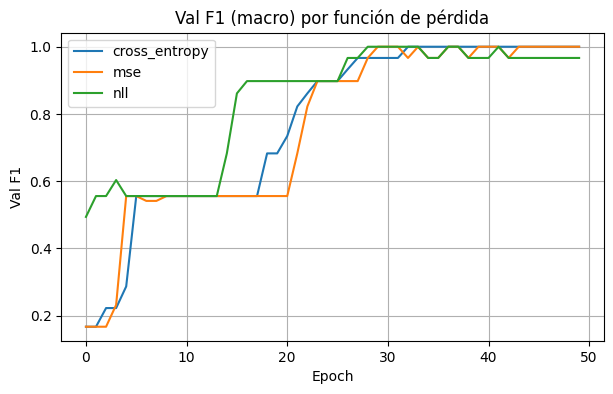

In [ ]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

def loss_function(loss_name: str):
    loss_name = loss_name.lower()
    if loss_name == 'cross_entropy':
        return nn.CrossEntropyLoss()
    elif loss_name == 'mse':
        return nn.MSELoss()
    elif loss_name == 'nll':
        return nn.NLLLoss()
    else:
        raise ValueError(f"Función de pérdida no soportada: {loss_name}")

def accuracy_from_logits(logits: torch.Tensor, y_true: torch.Tensor) -> float:
    preds = logits.argmax(1)
    return (preds == y_true).float().mean().item()

def f1_from_logits(logits: torch.Tensor, y_true: torch.Tensor) -> float:
    preds = logits.argmax(1).cpu().numpy()
    y_np = y_true.cpu().numpy()
    # macro-F1 por clases balanceadas en Iris
    return f1_score(y_np, preds, average='macro')

def train_model_batch_gd(model, loss_fn, optimizer,
                        X_train, y_train, X_val, y_val,
                        epochs=50, verbose=True):
    history = {
        "train_loss": [], "val_loss": [],
        "train_acc":  [], "val_acc":  [],
        "train_f1":   [], "val_f1":   [],
    }

    for epoch in range(1, epochs+1):
        # train
        model.train()
        optimizer.zero_grad()
        logits = model(X_train)  

        if isinstance(loss_fn, nn.MSELoss):
            probs = F.softmax(logits, dim=1)
            y_train_oh = F.one_hot(y_train, num_classes=logits.size(1)).float()
            loss = loss_fn(probs, y_train_oh)
        elif isinstance(loss_fn, nn.NLLLoss):
            # log-probabilidades
            log_probs = F.log_softmax(logits, dim=1)
            loss = loss_fn(log_probs, y_train)
        else:
            loss = loss_fn(logits, y_train)

        loss.backward()
        optimizer.step()

        # Métricas de train
        train_loss = loss.item()
        train_acc = accuracy_from_logits(logits, y_train)
        train_f1  = f1_from_logits(logits, y_train)

        # validación
        model.eval()
        with torch.no_grad():
            logits_val = model(X_val)
            if isinstance(loss_fn, nn.MSELoss):
                probs_val = F.softmax(logits_val, dim=1)
                y_val_oh = F.one_hot(y_val, num_classes=logits_val.size(1)).float()
                val_loss_t = loss_fn(probs_val, y_val_oh)
            elif isinstance(loss_fn, nn.NLLLoss):
                log_probs_val = F.log_softmax(logits_val, dim=1)
                val_loss_t = loss_fn(log_probs_val, y_val)
            else:
                val_loss_t = loss_fn(logits_val, y_val)

            val_loss = val_loss_t.item()
            val_acc  = accuracy_from_logits(logits_val, y_val)
            val_f1   = f1_from_logits(logits_val, y_val)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_f1"].append(train_f1)
        history["val_f1"].append(val_f1)

        if verbose and (epoch % 5 == 0 or epoch == 1):
            print(f"Epoch {epoch:02d}/{epochs} | "
                f"Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} F1: {train_f1:.3f} | "
                f"Val Loss: {val_loss:.4f} Acc: {val_acc:.3f} F1: {val_f1:.3f}")

    return history

loss_functions = ['cross_entropy', 'mse', 'nll']
results = {}

for loss_name in loss_functions:
    print(f"\n=== Entrenando con función de pérdida: {loss_name} ===")
    model = FeedforwardNN(input_dim, hidden_dim, output_dim, p_dropout=0.0)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)  # Optimizador fijo por ahora
    loss_fn = loss_function(loss_name)
    history = train_model_batch_gd(
        model, loss_fn, optimizer,
        X_train_tensor, y_train_tensor,
        X_val_tensor,   y_val_tensor,
        epochs=50, verbose=True
    )
    results[loss_name] = history

def plot_history(results_dict, metric_key, title):
    plt.figure(figsize=(7,4))
    for name, hist in results_dict.items():
        plt.plot(hist[metric_key], label=f"{name}")
    plt.xlabel("Epoch")
    plt.ylabel(metric_key.replace("_", " ").title())
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(results, "train_loss", "Train Loss por función de pérdida")
plot_history(results, "val_loss",   "Val Loss por función de pérdida")
plot_history(results, "train_acc",  "Train Accuracy por función de pérdida")
plot_history(results, "val_acc",    "Val Accuracy por función de pérdida")
plot_history(results, "train_f1",   "Train F1 (macro) por función de pérdida")
plot_history(results, "val_f1",     "Val F1 (macro) por función de pérdida")

## Task 4 - Técnicas de Regularización


=== Regularización: no_reg ===
Epoch 01/50 | Train Loss: 1.1659 Acc: 0.042 F1: 0.027 | Val Loss: 1.1045 Acc: 0.333 F1: 0.167
Epoch 05/50 | Train Loss: 1.0060 Acc: 0.333 F1: 0.167 | Val Loss: 0.9708 Acc: 0.333 F1: 0.167
Epoch 10/50 | Train Loss: 0.7948 Acc: 0.667 F1: 0.556 | Val Loss: 0.7494 Acc: 0.667 F1: 0.556
Epoch 15/50 | Train Loss: 0.5873 Acc: 0.717 F1: 0.654 | Val Loss: 0.5439 Acc: 0.833 F1: 0.822
Epoch 20/50 | Train Loss: 0.4205 Acc: 0.850 F1: 0.842 | Val Loss: 0.3967 Acc: 0.900 F1: 0.898
Epoch 25/50 | Train Loss: 0.3019 Acc: 0.967 F1: 0.967 | Val Loss: 0.2846 Acc: 0.967 F1: 0.967
Epoch 30/50 | Train Loss: 0.2015 Acc: 0.967 F1: 0.967 | Val Loss: 0.1900 Acc: 1.000 F1: 1.000
Epoch 35/50 | Train Loss: 0.1312 Acc: 0.975 F1: 0.975 | Val Loss: 0.1258 Acc: 1.000 F1: 1.000
Epoch 40/50 | Train Loss: 0.0951 Acc: 0.983 F1: 0.983 | Val Loss: 0.0890 Acc: 1.000 F1: 1.000
Epoch 45/50 | Train Loss: 0.0795 Acc: 0.983 F1: 0.983 | Val Loss: 0.0696 Acc: 1.000 F1: 1.000
Epoch 50/50 | Train Loss: 0.

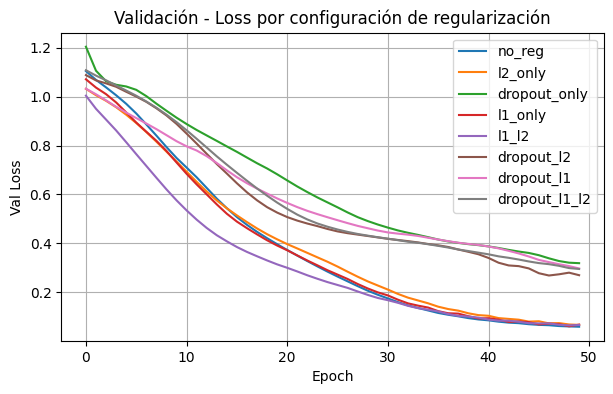

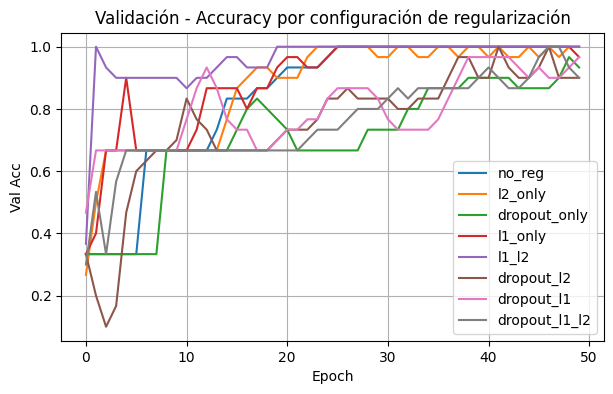

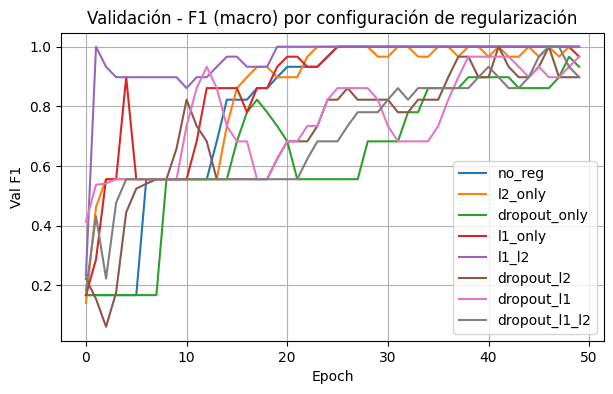

In [10]:

import time


def l1_penalty(model: nn.Module) -> torch.Tensor:
    l1 = 0.0
    for p in model.parameters():
        if p.requires_grad:
            l1 = l1 + p.abs().sum()
    return l1

# Entrenamiento con soporte de L1/L2/Dropout 
def train_with_regularization(
    loss_name: str,
    p_dropout: float = 0.0,     # Dropout
    l2_weight_decay: float = 0.0,  # L2 (weight decay del optimizador)
    l1_lambda: float = 0.0,        # L1 (término manual)
    lr: float = 1e-2,
    epochs: int = 50,
    verbose: bool = True
):
    
    model = FeedforwardNN(input_dim, hidden_dim, output_dim, p_dropout=p_dropout)

    # Loss
    loss_fn = loss_function(loss_name)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_weight_decay)

    # Historial
    history = {
        "train_loss": [], "val_loss": [],
        "train_acc":  [], "val_acc":  [],
        "train_f1":   [], "val_f1":   [],
        "config": {"loss": loss_name, "dropout": p_dropout,
                "l2_weight_decay": l2_weight_decay, "l1_lambda": l1_lambda}
    }

    start = time.time()
    for epoch in range(1, epochs+1):
        model.train()
        optimizer.zero_grad()

        logits = model(X_train_tensor)

        # Pérdida base según la loss seleccionada
        if isinstance(loss_fn, nn.MSELoss):
            probs = F.softmax(logits, dim=1)
            y_train_oh = F.one_hot(y_train_tensor, num_classes=logits.size(1)).float()
            base_loss = loss_fn(probs, y_train_oh)
        elif isinstance(loss_fn, nn.NLLLoss):
            log_probs = F.log_softmax(logits, dim=1)
            base_loss = loss_fn(log_probs, y_train_tensor)
        else: 
            base_loss = loss_fn(logits, y_train_tensor)

        # Agregar L1 si aplica
        if l1_lambda > 0.0:
            base_loss = base_loss + l1_lambda * l1_penalty(model)

        base_loss.backward()
        optimizer.step()

        # Métricas train
        train_loss = base_loss.item()
        train_acc  = (logits.argmax(1) == y_train_tensor).float().mean().item()
        train_f1   = f1_from_logits(logits, y_train_tensor)

        model.eval()
        with torch.no_grad():
            logits_val = model(X_val_tensor)
            if isinstance(loss_fn, nn.MSELoss):
                probs_val = F.softmax(logits_val, dim=1)
                y_val_oh = F.one_hot(y_val_tensor, num_classes=logits_val.size(1)).float()
                val_loss_t = loss_fn(probs_val, y_val_oh)
            elif isinstance(loss_fn, nn.NLLLoss):
                log_probs_val = F.log_softmax(logits_val, dim=1)
                val_loss_t = loss_fn(log_probs_val, y_val_tensor)
            else:
                val_loss_t = loss_fn(logits_val, y_val_tensor)

            val_loss = val_loss_t.item()
            val_acc  = (logits_val.argmax(1) == y_val_tensor).float().mean().item()
            val_f1   = f1_from_logits(logits_val, y_val_tensor)

        # Guardar
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_f1"].append(train_f1)
        history["val_f1"].append(val_f1)

        if verbose and (epoch % 5 == 0 or epoch == 1):
            print(f"Epoch {epoch:02d}/{epochs} | "
                f"Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} F1: {train_f1:.3f} | "
                f"Val Loss: {val_loss:.4f} Acc: {val_acc:.3f} F1: {val_f1:.3f}")

    history["time_s"] = time.time() - start
    return history


reg_experiments = {
    "no_reg":         dict(loss_name="cross_entropy", p_dropout=0.0, l2_weight_decay=0.0, l1_lambda=0.0),
    "l2_only":        dict(loss_name="cross_entropy", p_dropout=0.0, l2_weight_decay=1e-3, l1_lambda=0.0),
    "dropout_only":   dict(loss_name="cross_entropy", p_dropout=0.3, l2_weight_decay=0.0, l1_lambda=0.0),
    "l1_only":        dict(loss_name="cross_entropy", p_dropout=0.0, l2_weight_decay=0.0, l1_lambda=1e-5),
    "l1_l2":          dict(loss_name="cross_entropy", p_dropout=0.0, l2_weight_decay=1e-3, l1_lambda=1e-5),
    "dropout_l2":     dict(loss_name="cross_entropy", p_dropout=0.3, l2_weight_decay=1e-3, l1_lambda=0.0),
    "dropout_l1":     dict(loss_name="cross_entropy", p_dropout=0.3, l2_weight_decay=0.0, l1_lambda=1e-5),
    "dropout_l1_l2":  dict(loss_name="cross_entropy", p_dropout=0.3, l2_weight_decay=1e-3, l1_lambda=1e-5),
}

reg_results = {}
for name, cfg in reg_experiments.items():
    print(f"\n=== Regularización: {name} ===")
    hist = train_with_regularization(**cfg, epochs=50, verbose=True)
    reg_results[name] = hist

def plot_history(results_dict, metric_key, title):
    plt.figure(figsize=(7,4))
    for name, hist in results_dict.items():
        plt.plot(hist[metric_key], label=name)
    plt.xlabel("Epoch")
    plt.ylabel(metric_key.replace("_", " ").title())
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(reg_results, "val_loss", "Validación - Loss por configuración de regularización")
plot_history(reg_results, "val_acc",  "Validación - Accuracy por configuración de regularización")
plot_history(reg_results, "val_f1",   "Validación - F1 (macro) por configuración de regularización")


# Task 5 - Algoritmos de Optimización


=== Opt Experiment: BatchGD ===
Epoch 01/50 | Train Loss: 1.1177 Acc: 0.333 F1: 0.167 | Val Loss: 1.0885 Acc: 0.333 F1: 0.180
Epoch 05/50 | Train Loss: 1.0067 Acc: 0.342 F1: 0.184 | Val Loss: 0.9892 Acc: 0.333 F1: 0.167
Epoch 10/50 | Train Loss: 0.7898 Acc: 0.667 F1: 0.547 | Val Loss: 0.7191 Acc: 0.667 F1: 0.541
Epoch 15/50 | Train Loss: 0.4578 Acc: 0.742 F1: 0.696 | Val Loss: 0.4132 Acc: 0.900 F1: 0.898
Epoch 20/50 | Train Loss: 0.2908 Acc: 0.917 F1: 0.915 | Val Loss: 0.2674 Acc: 0.967 F1: 0.967
Epoch 25/50 | Train Loss: 0.1770 Acc: 0.933 F1: 0.933 | Val Loss: 0.1666 Acc: 0.967 F1: 0.967
Epoch 30/50 | Train Loss: 0.1289 Acc: 0.933 F1: 0.933 | Val Loss: 0.1370 Acc: 0.933 F1: 0.933
Epoch 35/50 | Train Loss: 0.1554 Acc: 0.942 F1: 0.941 | Val Loss: 0.2229 Acc: 0.867 F1: 0.861
Epoch 40/50 | Train Loss: 1.9364 Acc: 0.675 F1: 0.583 | Val Loss: 4.0329 Acc: 0.667 F1: 0.556
Epoch 45/50 | Train Loss: 1.3153 Acc: 0.667 F1: 0.556 | Val Loss: 0.9892 Acc: 0.533 F1: 0.432
Epoch 50/50 | Train Loss: 0

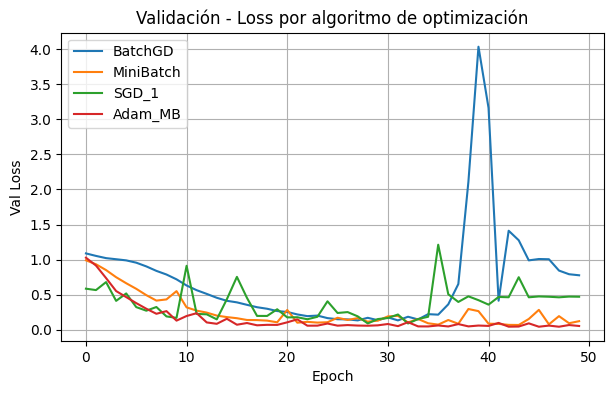

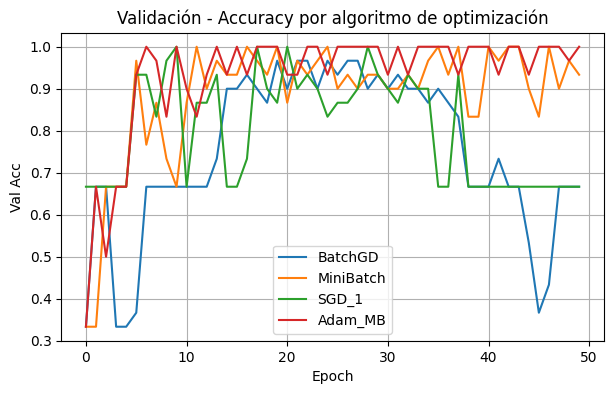

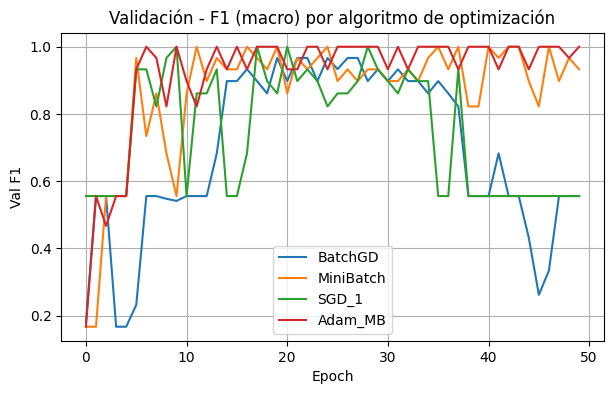

,exp,final_val_loss,final_val_acc,final_val_f1,time_s
3,Adam_MB,0.054484,1.000000,1.000000,1.158558
1,MiniBatch,0.123085,0.933333,0.932660,1.090619
0,BatchGD,0.776806,0.666667,0.555556,0.313451
2,SGD_1,0.471166,0.666667,0.555556,13.730088


In [14]:


from torch.utils.data import TensorDataset, DataLoader
import time
from collections import OrderedDict

def make_loaders(mode: str, mini_batch_size: int = 32, shuffle: bool = True):
    """
    mode in {"batch_gd", "mini_batch", "sgd"}
    - batch_gd: usa todo el dataset en un solo batch
    - mini_batch: usa mini_batch_size (p.ej. 32)
    - sgd: usa batch_size=1 (stochastic)
    """
    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    val_ds   = TensorDataset(X_val_tensor,   y_val_tensor)

    if mode == "batch_gd":
        bs = len(train_ds)  # full batch
    elif mode == "mini_batch":
        bs = mini_batch_size
    elif mode == "sgd":
        bs = 1
    else:
        raise ValueError(f"Modo no soportado: {mode}")

    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=shuffle)
    val_loader   = DataLoader(val_ds,   batch_size=len(val_ds), shuffle=False)
    return train_loader, val_loader

# --- Entrenamiento genérico con loaders ---
def train_with_loader(
    model,
    loss_fn,
    optimizer,
    train_loader,
    val_loader,
    epochs: int = 50,
    verbose: bool = True
):
    history = {
        "train_loss": [], "val_loss": [],
        "train_acc":  [], "val_acc":  [],
        "train_f1":   [], "val_f1":   [],
    }
    t0 = time.time()

    for epoch in range(1, epochs+1):
        # ----- TRAIN -----
        model.train()
        running_loss, correct, f1_parts = 0.0, 0, []
        n_total = 0

        for Xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(Xb)

            if isinstance(loss_fn, nn.MSELoss):
                probs = F.softmax(logits, dim=1)
                yb_oh = F.one_hot(yb, num_classes=logits.size(1)).float()
                loss = loss_fn(probs, yb_oh)
            elif isinstance(loss_fn, nn.NLLLoss):
                log_probs = F.log_softmax(logits, dim=1)
                loss = loss_fn(log_probs, yb)
            else:  # CrossEntropy
                loss = loss_fn(logits, yb)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * Xb.size(0)
            correct += (logits.argmax(1) == yb).sum().item()
            f1_parts.append(f1_from_logits(logits, yb))
            n_total += Xb.size(0)

        train_loss = running_loss / n_total
        train_acc  = correct / n_total
        train_f1   = np.mean(f1_parts)

        # ----- VAL -----
        model.eval()
        with torch.no_grad():
            val_loss_sum, val_correct, n_val = 0.0, 0, 0
            val_f1_parts = []
            for Xv, yv in val_loader:
                logits_v = model(Xv)
                if isinstance(loss_fn, nn.MSELoss):
                    probs_v = F.softmax(logits_v, dim=1)
                    yv_oh   = F.one_hot(yv, num_classes=logits_v.size(1)).float()
                    loss_v  = loss_fn(probs_v, yv_oh)
                elif isinstance(loss_fn, nn.NLLLoss):
                    log_probs_v = F.log_softmax(logits_v, dim=1)
                    loss_v = loss_fn(log_probs_v, yv)
                else:
                    loss_v = loss_fn(logits_v, yv)

                val_loss_sum += loss_v.item() * Xv.size(0)
                val_correct  += (logits_v.argmax(1) == yv).sum().item()
                val_f1_parts.append(f1_from_logits(logits_v, yv))
                n_val += Xv.size(0)

            val_loss = val_loss_sum / n_val
            val_acc  = val_correct / n_val
            val_f1   = np.mean(val_f1_parts)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_f1"].append(train_f1)
        history["val_f1"].append(val_f1)

        if verbose and (epoch % 5 == 0 or epoch == 1):
            print(f"Epoch {epoch:02d}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} F1: {train_f1:.3f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.3f} F1: {val_f1:.3f}")

    history["time_s"] = time.time() - t0
    return history

# --- Runner de experimentos de optimización ---
def run_optimizer_experiment(
    mode: str,                  # "batch_gd" | "mini_batch" | "sgd"
    loss_name: str = "cross_entropy",
    lr: float = 1e-2,
    weight_decay: float = 0.0,  # L2 opcional si quieres mantener constante con Task 4
    mini_batch_size: int = 32,
    epochs: int = 50,
    verbose: bool = True
):
    """
    Para 'batch_gd' usamos batch completo;
    para 'mini_batch' usamos batch=mini_batch_size;
    para 'sgd' usamos batch=1.
    El optimizador base será SGD; si quieres, puedes comparar también vs Adam como extra.
    """
    
    train_loader, val_loader = make_loaders(mode, mini_batch_size=mini_batch_size, shuffle=True)

    # Modelo y loss
    model = FeedforwardNN(input_dim, hidden_dim, output_dim, p_dropout=0.0)
    loss_fn = loss_function(loss_name)

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

    history = train_with_loader(
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=epochs,
        verbose=verbose
    )
    return history

opt_experiments = OrderedDict({
    "BatchGD":    dict(mode="batch_gd",  lr=5e-2,  mini_batch_size=32, epochs=50),
    "MiniBatch":  dict(mode="mini_batch",lr=1e-2,  mini_batch_size=16, epochs=50),
    "SGD_1":      dict(mode="sgd",       lr=5e-3,  mini_batch_size=1,  epochs=50),
    "Adam_MB":    dict(mode="mini_batch",lr=1e-2,  mini_batch_size=16, epochs=50), 
})

opt_results = {}
for name, cfg in opt_experiments.items():
    print(f"\n=== Opt Experiment: {name} ===")
    if name == "Adam_MB":
        train_loader, val_loader = make_loaders("mini_batch", mini_batch_size=cfg["mini_batch_size"], shuffle=True)
        model = FeedforwardNN(input_dim, hidden_dim, output_dim, p_dropout=0.0)
        loss_fn = loss_function("cross_entropy")
        optimizer = optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=0.0)
        hist = train_with_loader(model, loss_fn, optimizer, train_loader, val_loader, epochs=cfg["epochs"], verbose=True)
    else:
        hist = run_optimizer_experiment(**cfg)
    opt_results[name] = hist

def plot_history(results_dict, metric_key, title):
    plt.figure(figsize=(7,4))
    for name, hist in results_dict.items():
        plt.plot(hist[metric_key], label=name)
    plt.xlabel("Epoch")
    plt.ylabel(metric_key.replace("_", " ").title())
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(opt_results, "val_loss", "Validación - Loss por algoritmo de optimización")
plot_history(opt_results, "val_acc",  "Validación - Accuracy por algoritmo de optimización")
plot_history(opt_results, "val_f1",   "Validación - F1 (macro) por algoritmo de optimización")

rows = []
for name, hist in opt_results.items():
    rows.append({
        "exp": name,
        "final_val_loss": hist["val_loss"][-1],
        "final_val_acc":  hist["val_acc"][-1],
        "final_val_f1":   hist["val_f1"][-1],
        "time_s":         hist["time_s"],
    })
summary_df = pd.DataFrame(rows).sort_values(by="final_val_acc", ascending=False)
summary_df

# Task 6 - Experimentación y Análisis


=== Ejecutando: cross_entropy__no_reg ===

=== Ejecutando: cross_entropy__l2_only ===

=== Ejecutando: cross_entropy__dropout_only ===

=== Ejecutando: mse__no_reg ===

=== Ejecutando: mse__l2_only ===

=== Ejecutando: mse__dropout_only ===

=== Ejecutando: nll__no_reg ===

=== Ejecutando: nll__l2_only ===

=== Ejecutando: nll__dropout_only ===


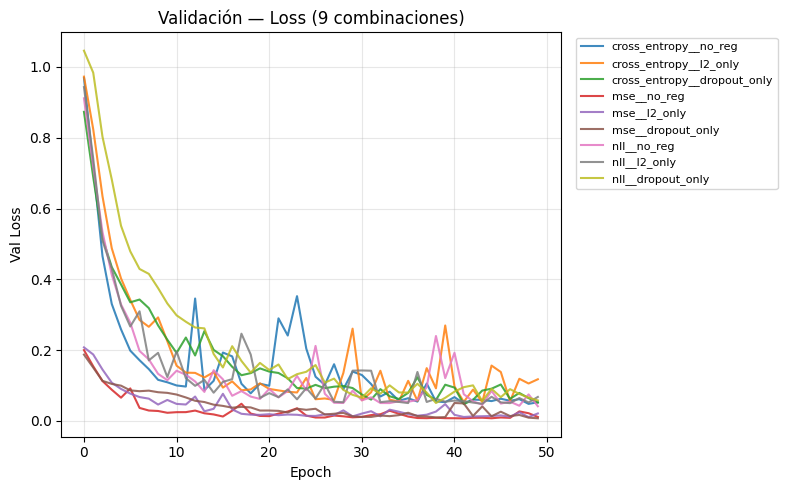

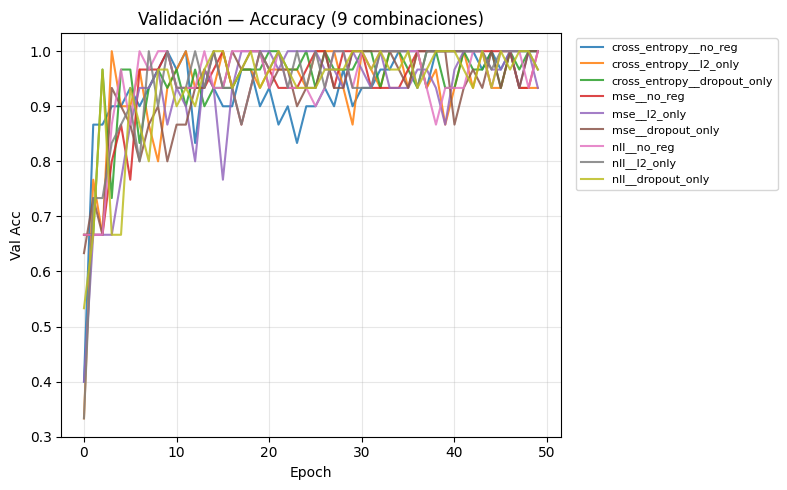

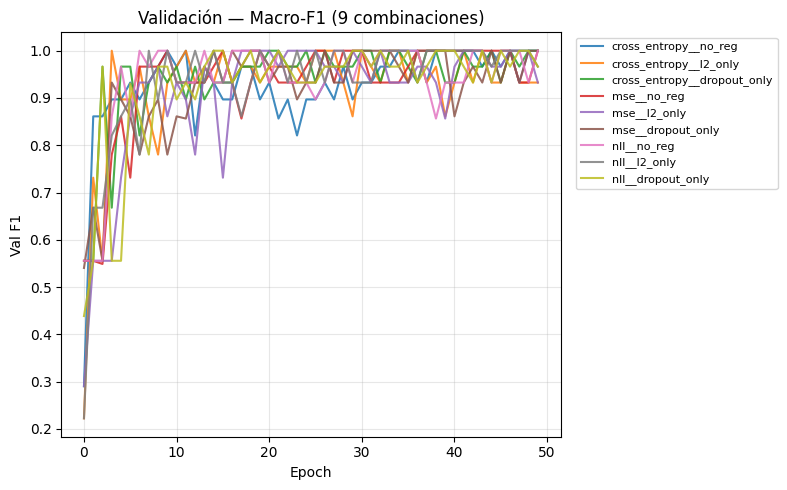

,combo,final_val_loss,final_val_acc,final_val_f1,time_s
0,cross_entropy__no_reg,0.052891,1.000000,1.00000,1.258620
1,cross_entropy__dropout_only,0.051746,1.000000,1.00000,1.443063
2,mse__no_reg,0.011278,1.000000,1.00000,1.425811
3,mse__dropout_only,0.007520,1.000000,1.00000,1.371833
4,nll__no_reg,0.041562,1.000000,1.00000,1.305877
5,nll__l2_only,0.067838,0.966667,0.96633,1.243452
6,nll__dropout_only,0.057964,0.966667,0.96633,1.286605
7,cross_entropy__l2_only,0.117792,0.933333,0.93266,1.349596
8,mse__l2_only,0.021194,0.933333,0.93266,1.364345


In [ ]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

def accuracy_from_logits(logits: torch.Tensor, y_true: torch.Tensor) -> float:
    preds = logits.argmax(1)
    return (preds == y_true).float().mean().item()

from sklearn.metrics import f1_score
def f1_from_logits(logits: torch.Tensor, y_true: torch.Tensor) -> float:
    preds = logits.argmax(1).cpu().numpy()
    y_np = y_true.cpu().numpy()
    return f1_score(y_np, preds, average='macro')

def l1_penalty(model: nn.Module) -> torch.Tensor:
    l1 = 0.0
    for p in model.parameters():
        if p.requires_grad:
            l1 = l1 + p.abs().sum()
    return l1

# DataLoaders (mini-batch)
def make_loaders(batch_size=16, shuffle=True):
    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    val_ds   = TensorDataset(X_val_tensor,   y_val_tensor)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# Entrenamiento (mini-batch) con L1/L2/Dropout y pérdidas múltiples
def train_one_experiment(
    loss_name: str,
    p_dropout: float = 0.0,      # Dropout
    l2_weight_decay: float = 0.0,# L2 (weight decay)
    l1_lambda: float = 0.0,      # L1 
    lr: float = 1e-2,
    batch_size: int = 16,
    epochs: int = 50,
    verbose: bool = False
):
    train_loader, val_loader = make_loaders(batch_size=batch_size, shuffle=True)
    model = FeedforwardNN(input_dim, hidden_dim, output_dim, p_dropout=p_dropout)
    loss_fn = loss_function(loss_name)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_weight_decay)

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc":  [], "val_acc":  [],
        "train_f1":   [], "val_f1":   [],
        "config": {"loss": loss_name, "dropout": p_dropout,
                "l2_weight_decay": l2_weight_decay, "l1_lambda": l1_lambda,
                "lr": lr, "batch_size": batch_size, "epochs": epochs}
    }

    t0 = time.time()
    for epoch in range(1, epochs+1):
        model.train()
        run_loss, run_correct, run_f1_parts, n = 0.0, 0, [], 0
        for Xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(Xb)

            # pérdida base según tipo
            if isinstance(loss_fn, nn.MSELoss):
                probs = F.softmax(logits, dim=1)
                yb_oh = F.one_hot(yb, num_classes=logits.size(1)).float()
                base_loss = loss_fn(probs, yb_oh)
            elif isinstance(loss_fn, nn.NLLLoss):
                log_probs = F.log_softmax(logits, dim=1)
                base_loss = loss_fn(log_probs, yb)
            else:  # CrossEntropy
                base_loss = loss_fn(logits, yb)

            # L1 opcional
            if l1_lambda > 0.0:
                base_loss = base_loss + l1_lambda * l1_penalty(model)

            base_loss.backward()
            optimizer.step()

            run_loss += base_loss.item() * Xb.size(0)
            run_correct += (logits.argmax(1) == yb).sum().item()
            run_f1_parts.append(f1_from_logits(logits, yb))
            n += Xb.size(0)

        tr_loss = run_loss / n
        tr_acc  = run_correct / n
        tr_f1   = float(np.mean(run_f1_parts))

        # ---- VALIDATION ----
        model.eval()
        val_loss_sum, val_correct, val_f1_parts, n_val = 0.0, 0, [], 0
        with torch.no_grad():
            for Xv, yv in val_loader:
                logits_v = model(Xv)
                if isinstance(loss_fn, nn.MSELoss):
                    probs_v = F.softmax(logits_v, dim=1)
                    yv_oh = F.one_hot(yv, num_classes=logits_v.size(1)).float()
                    loss_v = loss_fn(probs_v, yv_oh)
                elif isinstance(loss_fn, nn.NLLLoss):
                    log_probs_v = F.log_softmax(logits_v, dim=1)
                    loss_v = loss_fn(log_probs_v, yv)
                else:
                    loss_v = loss_fn(logits_v, yv)

                val_loss_sum += loss_v.item() * Xv.size(0)
                val_correct  += (logits_v.argmax(1) == yv).sum().item()
                val_f1_parts.append(f1_from_logits(logits_v, yv))
                n_val += Xv.size(0)

        va_loss = val_loss_sum / n_val
        va_acc  = val_correct / n_val
        va_f1   = float(np.mean(val_f1_parts))

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)
        history["train_f1"].append(tr_f1)
        history["val_f1"].append(va_f1)

        if verbose and (epoch % 5 == 0 or epoch == 1):
            print(f"Epoch {epoch:02d}/{epochs} | "
                  f"Train Loss: {tr_loss:.4f} Acc: {tr_acc:.3f} F1: {tr_f1:.3f} | "
                  f"Val Loss: {va_loss:.4f} Acc: {va_acc:.3f} F1: {va_f1:.3f}")

    history["time_s"] = time.time() - t0
    return history

losses = ["cross_entropy", "mse", "nll"]
regularizations = {
    "no_reg":       dict(p_dropout=0.0, l2_weight_decay=0.0, l1_lambda=0.0),
    "l2_only":      dict(p_dropout=0.0, l2_weight_decay=1e-3, l1_lambda=0.0),
    "dropout_only": dict(p_dropout=0.3, l2_weight_decay=0.0, l1_lambda=0.0),
}

task6_results = {}
for loss_name in losses:
    for reg_name, reg_cfg in regularizations.items():
        tag = f"{loss_name}__{reg_name}"
        print(f"\n=== Ejecutando: {tag} ===")
        hist = train_one_experiment(
            loss_name=loss_name,
            **reg_cfg,
            lr=1e-2,
            batch_size=16,
            epochs=50,
            verbose=False
        )
        task6_results[tag] = hist


def plot_history(results_dict, metric_key, title):
    plt.figure(figsize=(8,5))
    for name, hist in results_dict.items():
        plt.plot(hist[metric_key], label=name, alpha=0.85)
    plt.xlabel("Epoch")
    plt.ylabel(metric_key.replace("_", " ").title())
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 3 figuras: val_loss, val_acc, val_f1
plot_history(task6_results, "val_loss", "Validación — Loss (9 combinaciones)")
plot_history(task6_results, "val_acc",  "Validación — Accuracy (9 combinaciones)")
plot_history(task6_results, "val_f1",   "Validación — Macro-F1 (9 combinaciones)")


rows = []
for name, hist in task6_results.items():
    rows.append({
        "combo": name,
        "final_val_loss": hist["val_loss"][-1],
        "final_val_acc":  hist["val_acc"][-1],
        "final_val_f1":   hist["val_f1"][-1],
        "time_s":         hist["time_s"]
    })

summary_task6 = pd.DataFrame(rows).sort_values(by=["final_val_f1","final_val_acc"], ascending=[False, False]).reset_index(drop=True)
summary_task6


## Task 7 - Discusión de Resultados

<div align="justify">
En este ejercicio se analizaron los efectos de diferentes funciones de pérdida, técnicas de regularización y algoritmos de optimización en el entrenamiento de una red neuronal sobre el dataset Iris. 
</div>
<br>
<div align="justify">
En primer lugar, la elección de la función de pérdida resultó fundamental para el rendimiento del modelo. La función Cross-Entropy demostró ser la más adecuada para problemas de clasificación multiclase como el Iris, ya que permitió una convergencia rápida y estable, alcanzando altos valores de accuracy y F1. Por el otro lado, el uso de MSE (Error Cuadrático Medio), no es recomendable para clasificación debido a que su convergencia fue más lenta y el rendimiento final inferior debido a que no está diseñada para este tipo de tareas y puede generar gradientes menos informativos. La función NLL (Negative Log Likelihood) mostró un comportamiento similar a Cross-Entropy, pero requiere que las salidas del modelo sean log-probabilidades, lo que puede añadir cierta complejidad y, en algunos casos, una convergencia ligeramente más lenta. En resumen, para tareas de clasificación, Cross-Entropy es la opción preferida por su estabilidad y resultados superiores.
</div>
<br>
<div align="justify">
Respecto a las técnicas de regularización se observó que la ausencia de regularización puede llevar al sobreajuste aunque en el caso del dataset Iris este riesgo es bajo debido a su tamaño reducido. La regularización L2 (weight decay) ayudó a mejorar la generalización del modelo, penalizando los pesos grandes y aportando mayor estabilidad en la validación. En el caso del uso de Dropout introdujo aleatoriedad en el entrenamiento forzando al modelo a no depender excesivamente de neuronas específicas, lo que resultó en una mayor robustez y en ocasiones tener mejores valores de F1. Sin embargo, valores elevados de Dropout pueden dificultar la convergencia. La regularización L1, que promueve la dispersión de los pesos, tuvo un efecto menos notorio en este problema concreto. Además, la combinación de varias técnicas de regularización, como Dropout y L2, puede potenciar la generalización, aunque también puede ralentizar la convergencia si los hiperparámetros no se ajustan adecuadamente. En conclusión, L2 y Dropout fueron las técnicas más efectivas para mejorar la generalización en este contexto, y su combinación puede ser beneficiosa si se ajusta correctamente.
</div>
<br>
<div align="justify">
En cuanto a los algoritmos de optimización, se compararon Batch Gradient Descent, Mini-Batch Gradient Descent, SGD y Adam. En donde el método Batch Gradient Descent mostró una convergencia estable pero lenta, siendo menos eficiente en datasets grandes. Mini-Batch Gradient Descent ofreció un equilibrio óptimo entre estabilidad y velocidad, y es el estándar en la práctica moderna. El algoritmo SGD introdujo mucha variabilidad en las actualizaciones de los pesos, lo que puede ayudar a escapar de mínimos locales, pero su convergencia fue más ruidosa y lenta. Por último, Adam destacó por su rapidez y estabilidad en la convergencia, alcanzando buenos resultados en menos épocas y siendo menos sensible a la escala de los gradientes, lo que reduce la necesidad de ajustar manualmente la tasa de aprendizaje. Por tanto, Adam suele ser la opción preferida por su eficiencia y robustez, aunque Mini-Batch SGD también es una alternativa sólida.
</div>
<br>
<div align="justify">
Finalmente, al analizar la interacción entre las distintas técnicas, se observó que el mejor rendimiento se obtuvo al combinar Cross-Entropy, Adam y alguna forma de regularización como L2 o Dropout. Aunque la regularización es más crítica en datasets grandes o modelos complejos, incluso en un conjunto pequeño como Iris contribuye a la estabilidad del entrenamiento. Es importante destacar que la elección de la función de pérdida debe estar alineada con la naturaleza de la tarea (clasificación o regresión), y que los algoritmos de optimización modernos como Adam facilitan la obtención de buenos resultados sin requerir un ajuste exhaustivo de hiperparámetros.
</div>

# Ejercicio 2 - Repaso Teoría

### 1. *¿Cuál es la principal innovación de la arquitectura Transformer?*
<div align="justify">
La principal innovación de la arquitectura Transformer es que elimina por completo el uso de redes recurrentes (RNN) y convolucionales (CNN), ya que en su lugar se basa únicamente en mecanismos de atención en donde son  específicamente la auto-atención (self-attention) y la atención multi-cabeza (multi-head attention). Permitiendo que el modelo aprenda dependencias globales entre los elementos de la secuencia de entrada y salida de manera más eficiente y paralelizable. Como ventaja de la estructura el Transformer logra superar en calidad y velocidad de entrenamiento a los modelos tradicionales en donde permite procesar todas las posiciones de la secuencia en paralelo, teniendo como beneficio que facilita el aprendizaje de relaciones a largo plazo y reduciendo significativamente el tiempo de entrenamiento. Asimismo, esta arquitectura ha demostrado generalizar bien a otras tareas más allá de la traducción automática, estableciendo nuevos estándares de desempeño en diversos problemas de procesamiento de lenguaje natural.
<div>

### 2. *¿Cómo funciona el mecanismo de atención del scaled dot-product?*
El mecanismo de atención scaled dot-product funciona tomando tres elementos principales los cuales son queries, keys y values, todos representados como vectores. El proceso consiste en calcular el producto punto entre cada query y todas las keys, dividiendo el resultado por la raíz cuadrada de la dimensión de las keys, es decir:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Luego, se aplica una función softmax para obtener los pesos de atención, que determinan la importancia relativa de cada valor. Finalmente, se realiza una suma ponderada de los valores usando estos pesos, generando así la salida de la atención. Este mecanismo permite que el modelo enfoque su atención en diferentes partes de la secuencia de entrada, independientemente de la distancia entre los elementos, y es altamente eficiente y paralelizable gracias a su implementación basada en operaciones matriciales.

### 3. *¿Por qué se utiliza la atención de múltiples cabezales en Transformer?*
<div align="justify">

<div>

### 4. *¿Cómo se incorporan los positional encodings en el modelo Transformer?*
<div align="justify">

<div>

### 5. *¿Cuáles son algunas aplicaciones de la arquitectura Transformer más allá de la machine translation?*
<div align="justify">

<div>